## Ensemble Learning for Movie Recommendation System

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import torch
import torch.nn as nn

## Dataset Description and Visualtion

### Ratings

In [ ]:
ratings_df = pd.read_csv('ratings_small.csv',index_col=False,usecols=['userId','movieId','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
print('Number of users: '+str(ratings_df['userId'].nunique()))
print('Number of movies: '+str(ratings_df['movieId'].nunique()))
print('Number of user ratings: '+str(len(ratings_df)))

Number of users: 610
Number of movies: 9724
Number of user ratings: 100836


In [ ]:
ratings_df.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


Data Sparsity: Only 1.6% ratings

In [ ]:
ratings_df.shape[0]/(n_movies*n_users)

0.016999683055613623

### Movies

In [ ]:
movies_df = pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Top-10 Rated Movies

In [ ]:
x = ratings_df.groupby('movieId',as_index=False).userId.count()
movie = pd.merge(movies_df,x,how='outer',on='movieId')
movie.sort_values('userId',ascending=False,inplace=True)
movie = movie.rename({'userId': 'no_of_ratings'}, axis=1)
movie.head(10)

,movieId,title,genres,no_of_ratings
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.0
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.0
97,110,Braveheart (1995),Action|Drama|War,237.0
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.0
461,527,Schindler's List (1993),Drama|War,220.0


Top rated movie is Forest Gump (1994) with 329 ratings

Movie distribution by Rating count

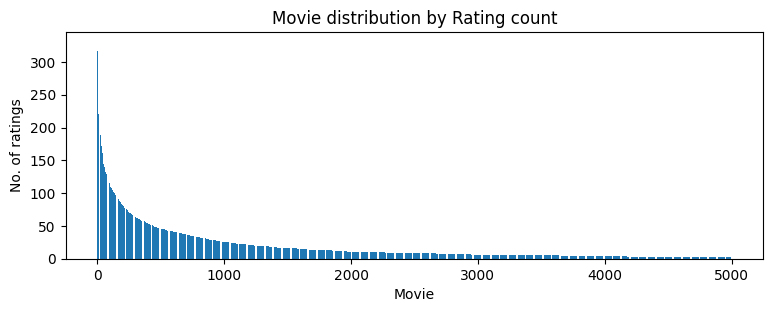

In [ ]:
p = sorted(list(x['userId']), reverse=True)[:5000]
plt.figure(figsize=(9, 3), dpi=100)
ax = plt.subplot(111)
ax.bar(range(5000), p)
plt.xlabel('Movie')
plt.ylabel('No. of ratings')
plt.title("Movie distribution by Rating count")
plt.show()

## Data Pre-processing

Train-test Split

In [ ]:
X_train, X_test = train_test_split(ratings_df, test_size=0.10)

In [ ]:
unique_movies_train = sorted(X_train['movieId'].unique())
X_train_movieid_to_index_map = {unique_movies_train[index]: index for index in range(0,len(unique_movies_train))}
unique_movies_test = sorted(X_test['movieId'].unique())
X_test_movieid_to_index_map = {unique_movies_test[index]: index for index in range(0,len(unique_movies_test))}

unique_users_train = sorted(X_train['userId'].unique())
X_train_userid_to_index_map = {unique_users_train[index]: index for index in range(0,len(unique_users_train))}
unique_users_test = sorted(X_test['userId'].unique())
X_test_userid_to_index_map = {unique_users_test[index]: index for index in range(0,len(unique_users_test))}

X_test_updated = [row for idx, row in X_test.iterrows() if row[0] in X_train_userid_to_index_map and row[1] in X_train_movieid_to_index_map]

Convert the dataset into a (movie x user) matrix


Handling Sparsity: Replace n/a values in the (movie x user) matrix with zeros

In [ ]:
def convert_to_matrix(X_data, n_users, n_movies, X_movieid_to_index_map, X_userid_to_index_map):
  data_matrix = np.zeros((n_movies, n_users))
  for line in X_data.itertuples():
    data_matrix[X_movieid_to_index_map[line[2]], X_userid_to_index_map[line[1]]] = line[3] 
  return data_matrix

In [ ]:
train_data_matrix = convert_to_matrix(X_train, n_users, n_movies, X_train_movieid_to_index_map, X_train_userid_to_index_map)
test_data_matrix = convert_to_matrix(X_test, n_users, n_movies, X_test_movieid_to_index_map, X_test_userid_to_index_map)

## Base Models

### User Based Collaborative Filtering (UBCF)

Given a user and a movie, predict what rating the user would give the movie

In [ ]:
def get_average_rating(movie_idxs, user_id, X_train):
  ratings = [X_train[movie_idx, user_id] for movie_idx in movie_idxs[0] if X_train[movie_idx, user_id] != 0.0]
  if not ratings:
    return 0.0
  return sum(ratings)/len(ratings)

def filter_movies_by_user(user_id, X_train):
  # get all movie indices rated by a user
  idxs = np.where(X_train[:,user_id] != 0)
  return idxs

def knn_user_based(train_data_matrix, X_test_csr, k, userId, movieId, num_recommendations, test=True):

  # if the user is new, no recommendation is given
  if userId not in X_train_userid_to_index_map:
    # print("No recommmendation (New user)!!")
    return np.nan

  # if the movie is new, no recommendation is given
  if movieId not in X_train_movieid_to_index_map:
    # print("No recommmendation (New movie)!!")
    return np.nan

  # get all movie indices rated by the user
  user_index = X_train_userid_to_index_map[userId]
  movie_idxs_rated_by_user = filter_movies_by_user(user_index, train_data_matrix)[0]

  # if the user has not rated sufficient movies (atleast k), no recommendation is given
  if (len(movie_idxs_rated_by_user) < k):
    # print("No recommmendation (not enough ratings)!!")
    return np.nan

  # filter x_train and keep movies rated by user
  X_train_filtered = train_data_matrix[movie_idxs_rated_by_user, :]
  
  # csr_matrix: ignore zeroes
  X_train_csr = csr_matrix(X_train_filtered)
  
  # fit the model
  recommender_knn = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=k)
  recommender_knn.fit(X_train_csr)

  # get the top nearest neighbors for the given movie
  # (movie vector as input) -> NN should give num_recommendations which are the most similar to this movie
  if test: 
    movie_idx = X_test_movieid_to_index_map[movieId]
    similarity, idxs = recommender_knn.kneighbors(X_test_csr[movie_idx],n_neighbors=num_recommendations+1)
  else:
    X_train_csr_unfiltered = csr_matrix(train_data_matrix)
    movie_idx = X_train_movieid_to_index_map[movieId]
    similarity, idxs = recommender_knn.kneighbors(X_train_csr_unfiltered[movie_idx],n_neighbors=num_recommendations+1)
  
  # return average rating
  return get_average_rating(idxs, user_index, X_train_csr)

Evaluation using Mean Square Error(MSE)

In [ ]:
def mse_user_based(train_data_matrix, X_test, test_data_matrix, k, num_recommendations):
  X_test_csr = csr_matrix(test_data_matrix)
  knn_user_based_ratings = [knn_user_based(train_data_matrix, X_test_csr, k=k, userId=row[0], movieId=row[1], num_recommendations = num_recommendations) for (idx, row) in X_test.iterrows()]
  return np.mean([(knn_user_based_ratings[i] - X_test.iloc[[i]]['rating'])**2 for i in range(len(X_test)) if not np.isnan(knn_user_based_ratings[i])])

In [ ]:
mse_user_based(train_data_matrix, X_test, test_data_matrix, k = 10, num_recommendations = 5)

1.0813273

Hyperparameter Tuning for k

In [ ]:
mse_user = []
for k in range(1, 80, 5):
    print(k)
    u = mse_user_based(train_data_matrix, X_test, test_data_matrix, k=k, num_recommendations=5)
    mse_user.append(u)
    print(u)
    print("----")

1
1.0746859
----
6
1.0746859
----
11
1.0746859
----
16
1.0746859
----
21
1.0740201
----
26
1.0707664
----
31
1.0699015
----
36
1.0701215
----
41
1.0717214
----
46
1.0756065
----
51
1.0762095
----
56
1.0786185
----
61
1.0766381
----
66
1.0733397
----
71
1.0764004
----
76
1.0728385
----


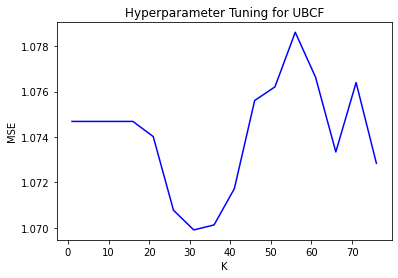

In [ ]:
x = [i for i in range(1, 80, 5)]
plt.figure()
ax = plt.subplot(111)
ax.plot(x,mse_user,linewidth=1.5,color='blue')
plt.xlabel('K')
plt.ylabel('MSE')
plt.title("Hyperparameter Tuning for UBCF")
plt.show()

Optimal K (UBCF): 35

### Movie Based Collaborative Filtering (IBCF)

Given a user and a movie, predict what rating the user would give the movie

In [ ]:
def filter_users_by_movie(movie_index, X_train):
  # get all user indices who have rated a movie
  idxs = np.where(X_train[movie_index,:] != 0)
  return idxs

def get_average_rating_user(user_idxs, movie_index, X_train):
  ratings = [X_train[user_index, movie_index] for user_index in user_idxs[0] if X_train[user_index, movie_index] != 0.0]
  if not ratings:
    return 0.0
  return sum(ratings)/len(ratings)

def knn_movie_based(train_data_matrix, X_test_csr, k, userId, movieId, num_recommendations, test=True):

  # if the user is new, no recommendation is given
  if userId not in X_train_userid_to_index_map:
    # print("No recommmendation (New user)!!")
    return np.nan

  # if the movie is new, no recommendation is given
  if movieId not in X_train_movieid_to_index_map:
    # print("No recommmendation (New movie)!!")
    return np.nan

  # get all user indices who have rated a movie
  movie_idx = X_train_movieid_to_index_map[movieId]
  user_idxs = filter_users_by_movie(movie_idx, train_data_matrix)[0]

  # if not enough users have rated the movie (atleast k), no recommendation is given
  if (len(user_idxs) < k):
    # print("No recommmendation (not enough ratings)!!")
    return np.nan

  # filter x_train and keep users who have rated the movie
  X_train_filtered = train_data_matrix[:, user_idxs]
  
  # csr_matrix: ignore zeroes
  X_train_csr = csr_matrix(X_train_filtered.T)
  
  # fit the model
  recommender_knn = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=k)
  recommender_knn.fit(X_train_csr)

  # get the top nearest neighbors for the given user
  # (user vector as input) -> NN should give num_recommendations which are the most similar to this user
  if test:
    user_index_test = X_test_userid_to_index_map[userId]
    try:
      similarity, idxs = recommender_knn.kneighbors(X_test_csr[user_index_test],n_neighbors=num_recommendations+1)
    except:
      return np.nan
  else:
    X_train_csr_unfiltered = csr_matrix(train_data_matrix)
    user_index_test = X_train_movieid_to_index_map[movieId]
    try:
      similarity, idxs = recommender_knn.kneighbors(X_train_csr_unfiltered[user_index_test],n_neighbors=num_recommendations+1)
    except:
      return np.nan
  
  # return average rating
  return get_average_rating_user(idxs, movie_idx, X_train_csr)

Evaluation using Mean Square Error(MSE)

In [ ]:
def mse_movie_based(train_data_matrix, X_test, test_data_matrix, k, num_recommendations):
  X_test_csr = csr_matrix(test_data_matrix.T)
  knn_movie_based_ratings = [knn_movie_based(train_data_matrix, X_test_csr, k=k, userId=row[0], movieId=row[1], num_recommendations = num_recommendations) for (idx, row) in X_test.iterrows()]
  return np.mean([(knn_movie_based_ratings[i] - X_test.iloc[[i]]['rating'])**2 for i in range(len(X_test)) if not np.isnan(knn_movie_based_ratings[i])])

In [ ]:
mse_movie_based(train_data_matrix, X_test, test_data_matrix, k = 10, num_recommendations = 5)

0.97582155

Hyperparameter Tuning for k

In [ ]:
mse_movie = []
for k in range(1, 80, 5):
    print(k)
    u = mse_movie_based(train_data_matrix, X_test, test_data_matrix, k=k, num_recommendations=5)
    mse_movie.append(u)
    print(u)
    print("----")

1
0.99947524
----
6
0.99947524
----
11
1.0090054
----
16
1.0088135
----
21
1.0121392
----
26
1.010689
----
31
1.0135125
----
36
1.0167755
----
41
1.0153508
----
46
1.0199274
----
51
1.0296712
----
56
1.0326494
----
61
1.0220529
----
66
1.0139055
----
71
1.0038409
----
76
1.0016366
----


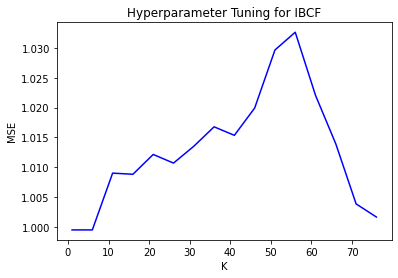

In [ ]:
x = [i for i in range(1, 80, 5)]
plt.figure()
ax = plt.subplot(111)
ax.plot(x,mse_movie,linewidth=1.5,color='blue')
plt.xlabel('K')
plt.ylabel('MSE')
plt.title("Hyperparameter Tuning for IBCF")
plt.show()

Optimal K (IBCF): 5

### Matrix Factorization

Matrix Factorization:  In this approach, the ratings matrix is decomposed into the product of two lower dimensionality rectangular matrices. 

In [ ]:
def get_error(R, P, Q, K, beta):
        """
        Calculates the error for the function
        :param R:
        :param P:
        :param Q:
        :param K:
        :param beta:
        :return:
        """
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:

                    # loss function error sum( (y-y_hat)^2 )
                    e = e + pow(R[i][j]-np.dot(P[i,:],Q[:,j]), 2)

                    # add regularization
                    for k in range(K):

                        # error + ||P||^2 + ||Q||^2
                        e = e + (beta/2) * ( pow(P[i][k], 2) + pow(Q[k][j], 2) )
        return e

In [ ]:
def factor_matrix(R, K=20, alpha=0.0002, steps=5000, beta=0.02, error_limit=0.001):
        """
        R = user x product matrix
        K = latent features count (how many features we think the model should derive)
        alpha = learning rate
        beta = regularization penalty (minimize over/under fitting)
        step = logistic regression steps
        error_limit = algo finishes when error reaches this level
        Returns:
        P = User x features matrix. (How strongly a user is associated with a feature)
        Q = Product x feature matrix. (How strongly a product is associated with a feature)
        To predict, use dot product of P, Q
        """
        # Transform regular array to numpy array
        R = np.array(R)

        # Generate P - N x K
        # Use random values to start. Best performance
        N = len(R)
        M = len(R[0])
        P = np.random.rand(N, K)

        # Generate Q - M x K
        # Use random values to start. Best performance
        Q = np.random.rand(M, K)
        Q = Q.T

        error = 0

        # iterate through max # of steps
        for step in range(steps):

            # iterate each cell in r
            for i in range(len(R)):
                for j in range(len(R[i])):
                    if R[i][j] > 0:

                        # get the eij (error) side of the equation
                        eij = R[i][j] - np.dot(P[i, :], Q[:, j])

                        for k in range(K):
                            # (*update_rule) update pik_hat
                            P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])

                            # (*update_rule) update qkj_hat
                            Q[k][j] = Q[k][j] + alpha * ( 2 * eij * P[i][k] - beta * Q[k][j] )

            # Measure error
            error = get_error(R, P, Q, K, beta)
            print("Error {}, step {}, k {}".format(error, step, K))
            # if step%100 == 0:
            #   print_fit_stats(error, N, M)

            # Terminate when we converge
            if error < error_limit:
                break

        # track Q, P (learned params)
        # Q = Products x feature strength
        # P = Users x feature strength
        Q = Q.T
        P = P
        return P @ Q.T

In [ ]:
def rmse_mf(X_data, x_pred):
  # 36744     249     6754     3.5
  X_data_updated = [row for idx, row in X_data.iterrows() if row[0] in X_train_userid_to_index_map and row[1] in X_train_movieid_to_index_map]
  return np.mean([(x_pred[X_train_movieid_to_index_map[row[1]]][X_train_userid_to_index_map[row[0]]] - row[2])**2  for row in X_data_updated])

In [ ]:
x_pred_mf = factor_matrix(R=train_data_matrix, K=60, alpha=0.002, steps=100, beta=0.02, error_limit=0.001)


Error 260804.19127135506, step 0, k 60
Error 176489.98071101104, step 1, k 60
Error 146341.8023232675, step 2, k 60
Error 128968.36959931992, step 3, k 60
Error 117281.04176701125, step 4, k 60
Error 108793.78767595722, step 5, k 60
Error 102302.25841142882, step 6, k 60
Error 97120.53402000359, step 7, k 60
Error 92832.83180332047, step 8, k 60
Error 89179.71950142815, step 9, k 60
Error 85994.54394451097, step 10, k 60
Error 83166.53362291386, step 11, k 60
Error 80619.43698808351, step 12, k 60
Error 78299.04359495909, step 13, k 60
Error 76165.7101676259, step 14, k 60
Error 74189.73318889491, step 15, k 60
Error 72348.38325455195, step 16, k 60
Error 70623.9421150098, step 17, k 60
Error 69002.3654636582, step 18, k 60
Error 67472.34881054016, step 19, k 60
Error 66024.66065266762, step 20, k 60
Error 64651.65762195008, step 21, k 60
Error 63346.92648557242, step 22, k 60
Error 62105.016431484946, step 23, k 60
Error 60921.23677040051, step 24, k 60
Error 59791.502750099775, step 

In [ ]:
# get accuracy on training data with steps = 100

train_accuracy = rmse_mf(X_train, x_pred_mf)
print("Matrix factorization train accuracy {}".format(train_accuracy))

# get accuracy on test data

test_accuracy = rmse_mf(X_test, x_pred_mf)
print("Matrix factorization test accuracy {}".format(test_accuracy))

Matrix factorization train accuracy 0.11576250135919434
Matrix factorization test accuracy 1.1033385214902396


In [ ]:
rmse_with_steps = []
rmse_with_alpha = []
rmse_with_k = []

for step in range(1, 1000, 200):
  x_pred_mf = factor_matrix(R=train_data_matrix, K=5, alpha=0.0002, steps=step, beta=0.02, error_limit=0.001)
  rmse_with_steps.append(rmse_mf(X_test, x_pred_mf))

alpha = 0.0001
for alpha in range(5):
  x_pred_mf = factor_matrix(R=train_data_matrix, K=5, alpha=alpha, steps=1000, beta=0.02, error_limit=0.001)
  rmse_with_alpha.append(rmse_mf(X_test, x_pred_mf))
  alpha = alpha * 5


print(rmse_with_steps)
print(rmse_with_alpha)
print(rmse_with_k)


## Ensemble Learning

### Data Preparation

Prepare Training and Test Data for the Ensemble: Run the Base Models on the Training and Test Data


UBCF

In [ ]:
k = 35

# knn_user_based_ratings_train = []
X_test_csr = csr_matrix(test_data_matrix)
# for (idx, row) in X_train.iterrows():
#   knn_user_based_ratings_train.append(knn_user_based(train_data_matrix, X_test_csr, k=k, userId=row[0], movieId=row[1], num_recommendations = 5, test=False))
# X_train['ubcf_rating'] = knn_user_based_ratings_train

knn_user_based_ratings_test = []
for (idx, row) in X_test.iterrows():
  knn_user_based_ratings_test.append(knn_user_based(train_data_matrix, X_test_csr, k=k, userId=row[0], movieId=row[1], num_recommendations = 5, test=False))
X_test['ubcf_rating'] = knn_user_based_ratings_test

IBCF

In [ ]:
k = 25

X_test_csr = csr_matrix(test_data_matrix.T)
# knn_movie_based_ratings_train = []
# for (idx, row) in X_train.iterrows():
#   knn_movie_based_ratings_train.append(knn_movie_based(train_data_matrix, X_test_csr, k=k, userId=row[0], movieId=row[1], num_recommendations = 5))
# X_train['ibcf_rating'] = knn_movie_based_ratings_train

knn_movie_based_ratings_test = []
for (idx, row) in X_test.iterrows():
  knn_movie_based_ratings_test.append(knn_movie_based(train_data_matrix, X_test_csr, k=k, userId=row[0], movieId=row[1], num_recommendations = 5))
X_test['ibcf_rating'] = knn_movie_based_ratings_test

Matrix Factorization

In [ ]:
predicted_ratings = []
actual_ratings = []
ratings = []

# run matrix factorization to decompose the ratings matrix
k = 60
x_pred_mf = factor_matrix(R=train_data_matrix, K=k, alpha=0.001, steps=100, beta=0.02, error_limit=0.01)

# get matrix_factorization prediction on training data
for (i,row) in X_train.iterrows():
  userIndex = X_train_userid_to_index_map[row[0]]
  movieIndex = X_train_movieid_to_index_map[row[1]]
  rating_predicted = x_pred_mf[movieIndex][userIndex]
  predicted_ratings.append(rating_predicted)
  actual_ratings.append(row[2])
  ratings.append([rating_predicted, row[2]])

In [ ]:
predicted_ratings = []
actual_ratings = []
ratings = []

# run matrix factorization to decompose the ratings matrix
k = 60
x_pred_mf = factor_matrix(R=train_data_matrix, K=k, alpha=0.001, steps=100, beta=0.02, error_limit=0.01)

# get matrix_factorization prediction on test data
for (i,row) in X_test.iterrows():
  userIndex = X_test_userid_to_index_map[row[0]]
  movieIndex = X_test_movieid_to_index_map[row[1]]
  rating_predicted = x_pred_mf[movieIndex][userIndex]
  predicted_ratings.append(rating_predicted)
  actual_ratings.append(row[2])
  ratings.append([rating_predicted, row[2]])

print(ratings)

Error 330703.7737318557, step 0, k 60
Error 220005.48641007833, step 1, k 60
Error 179658.3458618795, step 2, k 60
Error 157444.3511269315, step 3, k 60
Error 142702.3321958601, step 4, k 60
Error 131902.71982926628, step 5, k 60
Error 123529.37428581664, step 6, k 60
Error 116805.52650691898, step 7, k 60
Error 111276.49672758809, step 8, k 60
Error 106647.31279794736, step 9, k 60
Error 102711.88306639977, step 10, k 60
Error 99319.2577383399, step 11, k 60
Error 96355.96191758392, step 12, k 60
Error 93735.600739045, step 13, k 60
Error 91391.97609635649, step 14, k 60
Error 89274.12455832756, step 15, k 60
Error 87342.59183192444, step 16, k 60
Error 85566.60941021169, step 17, k 60
Error 83921.96588273712, step 18, k 60
Error 82389.41549509841, step 19, k 60
Error 80953.49584914032, step 20, k 60
Error 79601.6514981396, step 21, k 60
Error 78323.5829637994, step 22, k 60
Error 77110.76046191968, step 23, k 60
Error 75956.05764642959, step 24, k 60
Error 74853.47298759028, step 25,

In [ ]:
X_test['predicted_mf'] = predicted_ratings

In [ ]:
X_test.to_csv("x_test_ensemble.csv")

Training Data for the Ensemble will look something like this:

In [ ]:
ratings_df = pd.read_csv('ensemble_all_data.csv',index_col=False,usecols=['ubcf_rating','ibcf_rating','predicted_mf', 'rating'])
ratings_df = ratings_df[['ubcf_rating','ibcf_rating','predicted_mf', 'rating']]
ratings_df = ratings_df.rename({'rating':'actual'}, axis=1)
ratings_df.head(10)

,ubcf_rating,ibcf_rating,predicted_mf,actual
0,3.833333,3.916667,3.126491,4.0
1,4.500000,NaN,3.789080,4.0
2,4.333333,3.833333,4.113301,4.0
3,4.166667,4.250000,4.061168,5.0
4,4.500000,4.583333,3.069620,5.0
5,4.333333,NaN,4.377103,3.0
6,4.333333,NaN,3.073135,5.0
7,4.000000,4.333333,3.222274,4.0
8,4.500000,NaN,2.536811,5.0
9,4.500000,NaN,1.652030,5.0


Handling Sparsity: Replace NaN values with zeros

In [ ]:
X_train = ratings_df.dropna()
X_train.shape

(26420, 4)

In [ ]:
ratings_df = pd.read_csv('x_test_ensemble.csv',index_col=False,usecols=['ubcf_rating','ibcf_rating','predicted_mf', 'rating'])
ratings_df = ratings_df[['ubcf_rating','ibcf_rating','predicted_mf', 'rating']]
ratings_df = ratings_df.rename({'rating':'actual'}, axis=1)
X_test = ratings_df.dropna()
X_test.shape

(5562, 4)

Convert to a Supervised Learning format: X, y

In [ ]:
y_true = X_train['actual']
X_train = X_train.iloc[:, :-1]
y_true_test = X_test['actual']
X_test = X_test.iloc[:, :-1]

Evaluation using Mean Square Error(MSE)

In [ ]:
def mse(y_true, y_pred):
  return np.mean([(y_true[i] - y_pred[i])**2 for i in range(len(y_pred))])

### Mean

In [ ]:
y_pred = X_test.mean(axis = 1)
# test accuracy
print(mse(list(y_true_test), list(y_pred)))

0.8728088405802404


### Ordinary Least Squares (OLS)

In [ ]:
OLS = linear_model.LinearRegression(fit_intercept=False) # handle intercept explicitly
OLS.fit(X_train,y_true)

LinearRegression(fit_intercept=False)

In [ ]:
# Predicted labels from the model, test accuracy
y_pred = OLS.predict(X_test)
mse(list(y_true_test), y_pred)

0.6870202588939546

### Gradient Boosting Regressor

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_true)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
y_pred = gbrt.predict(X_test)
print(mse(list(y_true_test), y_pred))

0.7500779289715223


### Support Vector Machine (SVM)

In [ ]:
model = SVR(kernel='linear')
model.fit(X_train, y_true)

SVR(kernel='linear')

In [ ]:
model.predict(X_test)
print(mse(list(y_true_test), y_pred))

0.7500779289715223
